In [1]:
%load_ext autoreload

In [2]:
%autoreload 2

In [3]:
cd ..

C:\Users\Sommer Lab\Documents\Analysis Code


In [237]:
import sys
# sys.path.append(r'C:\Users\Sommer Lab\Documents\Analysis Code')
import os
from scipy.optimize import curve_fit
from scipy.ndimage import rotate
from scipy.integrate import simpson

from ImageAnalysis import ImageAnalysisCode
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

In [240]:
from scipy import signal
from scipy.ndimage import gaussian_filter1d
from skimage.filters import threshold_otsu
import pickle

In [340]:
plt.rcParams['figure.figsize'] = [10,8]
plt.rcParams['image.cmap'] = 'jet'
plt.rcParams['image.interpolation'] = 'nearest'

In [5]:
def Gaussian(x, amp, center, w, offset=0):
    return amp * np.exp(-0.5*(x-center)**2/w**2) + offset

In [6]:
def DoubleGaussian(x, amp1, amp2, center1, center2, width1, width2, offset):    
    g1 = Gaussian(x, amp1, center1, width1)
    g2 = Gaussian(x, amp2, center2, width2)
    return g1 + g2 + offset

In [147]:
def MultiGaussian(x, *params):
    L = len(params)        
    if  L % 3 != 1:
        raise TypeError('The number of parameters provided to MultiGaussian() besides x variable should be 3N+1, N is the number of Gaussian curves.')

    result = np.zeros(len(x))
    N = L//3
    
    for n in range(N):
        result += Gaussian(x, *params[n:-1:N])
        # print(params[n:-1:N])
    return result + params[-1]
        

In [470]:
def plotMultiGaussian(x, *params):
    L = len(params)        
    if  L % 3 != 1:
        raise TypeError('The number of parameters provided to MultiGaussian() besides x variable should be 3N+1, N is the number of Gaussian curves.')

    N = L//3
    
    for n in range(N):
        plt.plot(Gaussian(x, *params[n:-1:N], params[-1]/N), label=['{:.2f}'.format(ii) for ii in params[n:-1:N]])
    plt.legend()
        # print(params[n:-1:N])

In [29]:
def fitDoubleGaussian(data, xdata=None, dx=1,
                      subtract_bg = True, signal_feature = 'wide', signal_width=10, fitbgDeg=5):
    
    if subtract_bg:
        bg = ImageAnalysisCode.fitbg(data, signal_feature=signal_feature, signal_width=signal_width, fitbgDeg=fitbgDeg) 
        data = data - bg        
        offset = 0
    else:
        offset = min( data[:10].mean(), data[-10:].mean() )
    
    peaks, properties = signal.find_peaks(data, 
#                                    prominence=0.1*(data.max()-data.min()), 
                                   width=3
                                  )
    
    print(peaks)

    #initial guess:
    widths = (properties['right_ips'] - properties['left_ips']) / 2
    guess = [*properties['prominences'], *peaks, *widths, offset]
    
    if xdata is None:
        xdata = np.arange( len(data) )
    
    try:
        popt, _ = curve_fit(DoubleGaussian, xdata, data, p0 = guess
                            , bounds=([0]*6 + [-np.inf], [np.inf]*7)
                            )
        
    except Exception as e:
        print(e)
        return None    
    
    return popt


In [735]:
def fitMultiGaussian(data, xdata=None, dx=1, NoOfModel='auto', 
                     subtract_bg=0, signal_feature='wide', signal_width=10, fitbgDeg=5,
                     amp=1, width=3, denoise=0):
    
    if subtract_bg:
        bg = ImageAnalysisCode.fitbg(data, signal_feature=signal_feature, signal_width=signal_width, fitbgDeg=fitbgDeg) 
        data = data - bg        
        offset = 0
    else:
        offset = min( data[:10].mean(), data[-10:].mean() )
    
    peaks, properties = DetectPeaks(data, amp, width, denoise)
    
    #initial guess:
    amps = properties['width_heights'] + properties['prominences'] / 2
    widths = (properties['right_ips'] - properties['left_ips']) / 2    
    
    N = len(peaks)
    # print(peaks)
    if NoOfModel != 'auto' and NoOfModel > N:
        D = NoOfModel - N
        N = NoOfModel
        amps = np.concatenate( (amps, [amps.mean()]*D) )
        peaks = np.concatenate( (peaks, [int(amps.mean()-20)]*D) )
        widths = np.concatenate( (widths, [int(widths.mean())]*D) )

    guess = [*amps, *peaks, *widths, offset]
    
    if xdata is None:
        xdata = np.arange( len(data) )
    
    try:
        minamps = 0.1*(data.max()-data.min())
        popt, _ = curve_fit(MultiGaussian, xdata, data, p0 = guess,
                            bounds=([minamps]*N + [0]*N + [3]*N + [-np.inf], [np.inf]*(3*N+1))
                            )
        
    except Exception as e:
        print(e)
        return None    
    popt[2:-1] *= dx
    return popt

In [740]:
def DetectPeaks(yy, amp=1, width=3, denoise=0, doPlot=0):
    
    yycopy = yy.copy()
    
    if denoise:
        yycopy = gaussian_filter1d(yy, 3)
    
    # Determine the background with the otsu method and set to 0.
    thr = threshold_otsu(yycopy)
    yycopy[yycopy < thr] = 0    

    peaks, properties = signal.find_peaks(yycopy, prominence=amp*0.01*(yycopy.max()-yycopy.min()), width=width)

    if doPlot:
        plt.plot(yy, '--')
        plt.plot(yycopy, '.g')
        plt.vlines(x=peaks, ymin=yy[peaks] - properties["prominences"],
                   ymax = yy[peaks], color = "C1")
        plt.hlines(y=properties["width_heights"], xmin=properties["left_ips"],
                   xmax=properties["right_ips"], color = "C1")
    return peaks, properties


### Generate signal

In [704]:
p1 = [12, 27, 7]
p2 = [11, 45, 4]
p3 = [13, 60, 5]
offset = 0

pp = list(zip( p2, p3))
params = ()
for p in pp:
    params += p
params += (offset,)
params = np.array(params) *2
params

array([ 22,  26,  90, 120,   8,  10,   0])

In [705]:
xx = np.arange(200)

In [706]:
yy = MultiGaussian(xx, *params) + np.random.random(len(xx))*2

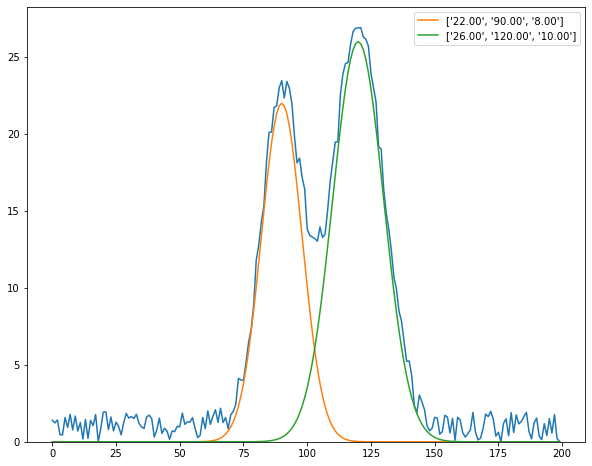

In [707]:
plt.plot(yy)
plotMultiGaussian(xx, *params)
plt.ylim([0, None]);

### Detect peaks directly

(array([121], dtype=int64),
 {'prominences': array([26.9147696]),
  'left_bases': array([79], dtype=int64),
  'right_bases': array([135], dtype=int64),
  'widths': array([25.43304603]),
  'width_heights': array([13.4573848]),
  'left_ips': array([106.82949271]),
  'right_ips': array([132.26253874])})

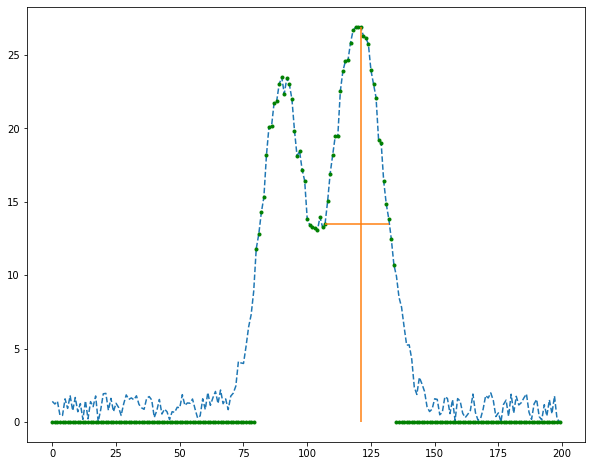

In [736]:
DetectPeaks(yy, doPlot=1)

### Fit the curve

In [737]:
popt = fitMultiGaussian(yy, 
                        NoOfModel=2
                       )
popt

array([ 2.32816422e+01,  2.69103666e+00,  1.08813806e+02,  1.13021726e-12,
        2.25338976e+01,  2.58756968e+01, -5.09055248e-01])

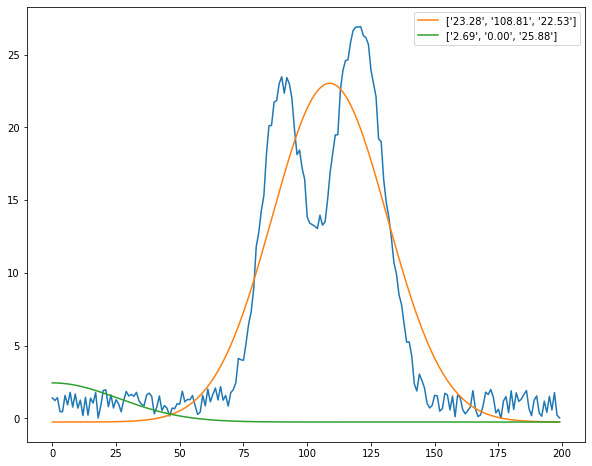

In [738]:
plt.plot(yy)
plotMultiGaussian(xx, *popt)

In [405]:
if (N = 5-3) > 0:
    print('asdf')

SyntaxError: invalid syntax (Temp/ipykernel_26392/3080409042.py, line 1)

### Try filter the signal

In [272]:
sos = signal.iirfilter(1, Wn=0.5, fs=30, btype="lowpass",
                             ftype="butter", output="sos")
yfilt = signal.sosfilt(sos, yy)

In [276]:
ygau = gaussian_filter1d(yy, 5)

(array([21, 67, 81], dtype=int64),
 {'prominences': array([10.17415034,  0.02593261,  0.03219542]),
  'left_bases': array([ 0, 61, 74], dtype=int64),
  'right_bases': array([89, 89, 89], dtype=int64),
  'widths': array([23.04469274,  5.78058962,  6.07966234]),
  'width_heights': array([7.19306801, 0.4404464 , 0.42685151]),
  'left_ips': array([ 9.49169803, 63.81529345, 77.46601848]),
  'right_ips': array([32.53639077, 69.59588306, 83.54568082])})

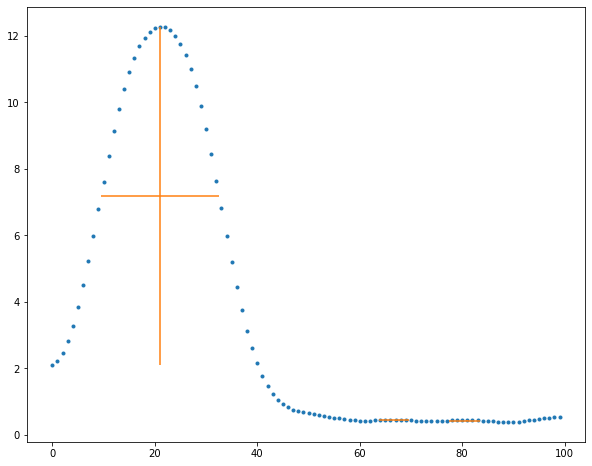

In [277]:
DetectPeaksAndPlot(ygau)

[23 56 88]


(array([23, 56, 88], dtype=int64),
 {'prominences': array([11.66898459,  0.05494279,  0.06060299]),
  'left_bases': array([ 0, 50, 68], dtype=int64),
  'right_bases': array([68, 68, 93], dtype=int64),
  'widths': array([23.6418334 ,  6.548183  ,  5.34187555]),
  'width_heights': array([6.80551404, 0.51166772, 0.50996244]),
  'left_ips': array([ 9.14573299, 53.12632844, 85.28293735]),
  'right_ips': array([32.78756639, 59.67451145, 90.62481289])})

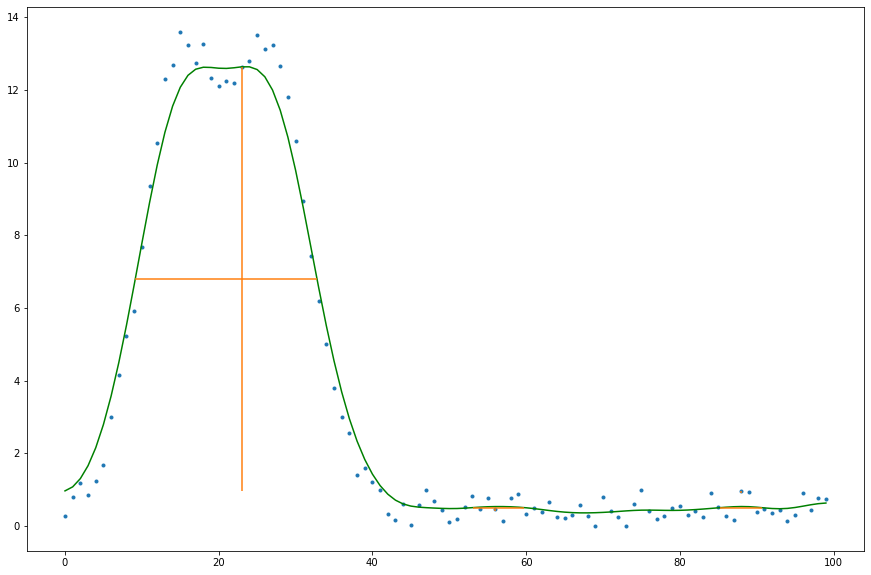

In [225]:
DetectPeaksAndPlot(yy, smooth=1)

In [279]:
popt = fitMultiGaussian(yy, xx, subtract_bg=0)
popt

[26]


array([14.02329725, 21.03639862,  9.18481074,  0.29910791])

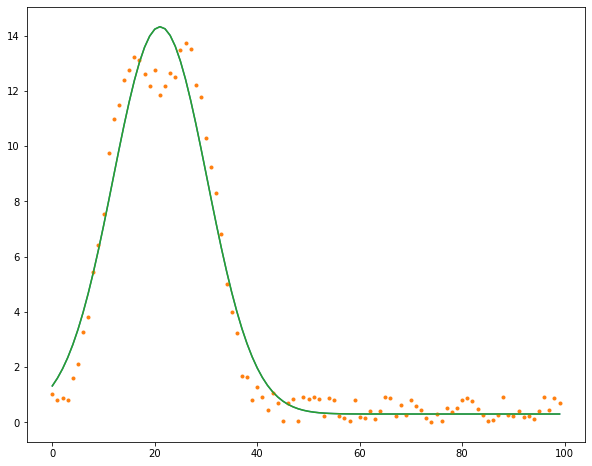

In [280]:
xx = np.arange(0,100)
plt.plot( xx, MultiGaussian(xx, *popt) )
plt.plot( xx, yy, '.')

plotMultiGaussian( xx, *popt )

In [50]:
for ii in range(0,9,3):
    print(ii)

0
3
6


In [26]:
aa

In [36]:
try:
    runoob()
except NameError as error:
    print(error)
else:
    try:
        with open('file.log') as file:
            read_data = file.read()
    except FileNotFoundError as fnf_error:
        print(fnf_error)
finally:
    print('这句话，无论异常是否发生都会执行。')


name 'runoob' is not defined
这句话，无论异常是否发生都会执行。


In [31]:
try:
    runoob()
except AssertionError as error:
    print(error)
else:
    try:
        with open('file.log') as file:
            read_data = file.read()
    except FileNotFoundError as fnf_error:
        print(fnf_error)
finally:
    print('这句话，无论异常是否发生都会执行。')

这句话，无论异常是否发生都会执行。


NameError: name 'runoob' is not defined

In [333]:
f = r'D:\Dropbox (Lehigh University)\Sommer Lab Shared\Data\2024\03-2024\06 Mar 2024\Basler\ODT 1900 Align'

In [334]:
# Load the Basler pictures
data_folder_Basler = f
files = os.listdir(data_folder_Basler)
fileNo = len(files)

imgs_Basler = []
for file in files:
    path = os.path.join(data_folder_Basler, file)
    imgs_Basler.append( plt.imread(path)[...,0] )
imgs_Basler = np.array(imgs_Basler)

In [336]:
files

['-1.png',
 '-2.png',
 '-3.png',
 '-4.png',
 '-5.png',
 '1.png',
 '2.png',
 '3.png',
 '4.png',
 '5.png']

(1530.0, 1700.0)

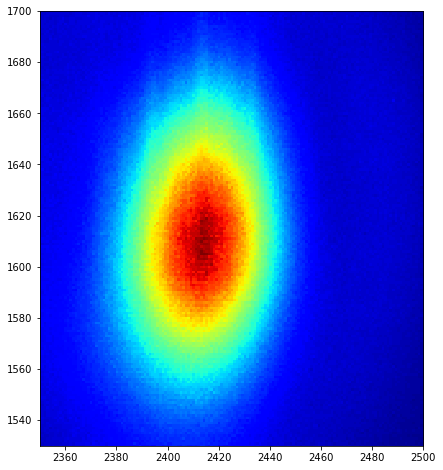

In [343]:
plt.imshow(imgs_Basler[-1])
plt.xlim([2350, 2500])
plt.ylim([1530, 1700])

In [335]:
np.array(popt_Basler)

array([[2.83415415e+01, 1.84579114e+03, 3.24082751e+01, 5.95910948e+00],
       [2.69301596e+01, 1.80603180e+03, 3.36630482e+01, 6.27776447e+00],
       [2.59713545e+01, 1.75720073e+03, 3.39320467e+01, 6.54570998e+00],
       [2.59020711e+01, 1.90065504e+03, 3.41534324e+01, 1.02083250e+00]])

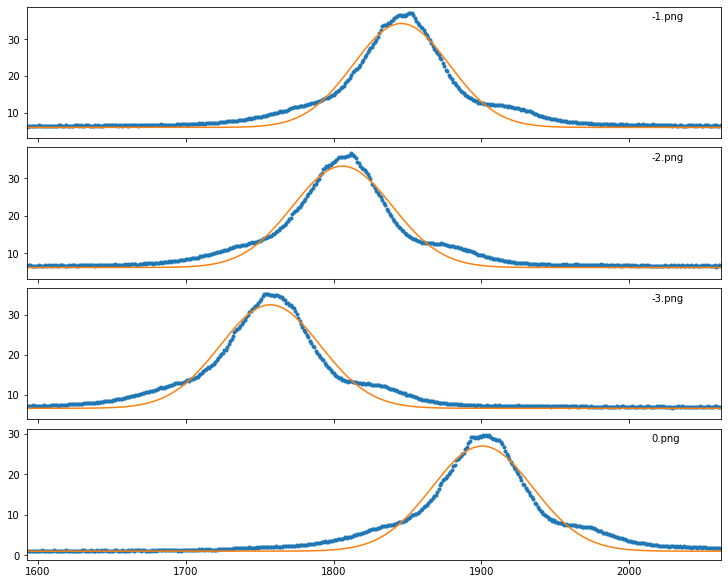

In [330]:
# Fit 1-D picture
imgs_oneD = imgs_Basler.sum(axis=1)

popt_Basler=[]
for ii in imgs_oneD:
    popt = ImageAnalysisCode.fitSingleGaussian(ii, signal_feature='narrow')
    popt_Basler.append(popt)

if 1:
    xx = np.arange(len(imgs_oneD[0]))
    fig, axes = plt.subplots(fileNo, 1, sharex=True, layout='constrained')
    for ii in range(fileNo):
        
        axes[ii].plot(imgs_oneD[ii], '.')
        axes[ii].plot(xx, ImageAnalysisCode.Gaussian(xx, *popt_Basler[ii]))
        axes[ii].text(0.9,0.9, files[ii], transform=axes[ii].transAxes)

    c, w = np.array(popt_Basler).mean(axis=0)[1:-1]
    axes[-1].set(xlim=[c-7*w, c+7*w])
        

In [249]:
# Extract the position of the light and the misalign value into a pd dataframe        
center_Basler = [ii[1] for ii in popt_Basler]
odtMisalign = [ int(ii.split('.')[0]) for ii in files]

dfBasler = pd.DataFrame({'ODT_Misalign': odtMisalign, 'center_Basler': center_Basler}).set_index('ODT_Misalign')
dfBasler

,center_Basler
ODT_Misalign,
-1,1845.791141
-2,1806.031805
-3,1757.200734
0,1900.655037


In [250]:
dfZyla = r'C:\Users\Sommer Lab\Documents\Analysis Code\Applications\testdata.pkl'
with open(dfZyla, 'rb') as f:
    results = pickle.load(f)

In [251]:
dfZyla = results[['ODT_Misalign', 'Ycenter']].set_index('ODT_Misalign')
dfZyla

,Ycenter
ODT_Misalign,
0.0,[382.9721439764404]
-1.0,"[380.17676368297754, 452.756021836862]"
-2.0,"[381.3833965450697, 508.6660571020489]"
-3.0,"[381.13283594356477, 563.9592504558186]"
1.0,"[327.11750361947503, 380.0572463490169]"
2.0,"[203.15162636822555, 380.0017724823788]"
3.0,"[152.24396992124946, 380.969665904088]"


In [254]:
dfjoin = dfBasler.join(dfZyla).sort_index()
dfjoin

,center_Basler,Ycenter
ODT_Misalign,,
-3,1757.200734,"[381.13283594356477, 563.9592504558186]"
-2,1806.031805,"[381.3833965450697, 508.6660571020489]"
-1,1845.791141,"[380.17676368297754, 452.756021836862]"
0,1900.655037,[382.9721439764404]


In [344]:
dfjoin

,center_Basler,Ycenter
ODT_Misalign,,
-3,1757.200734,"[381.13283594356477, 563.9592504558186]"
-2,1806.031805,"[381.3833965450697, 508.6660571020489]"
-1,1845.791141,"[380.17676368297754, 452.756021836862]"
0,1900.655037,[382.9721439764404]


In [345]:
dfjoin.reset_index()

,ODT_Misalign,center_Basler,Ycenter
0,-3,1757.200734,"[381.13283594356477, 563.9592504558186]"
1,-2,1806.031805,"[381.3833965450697, 508.6660571020489]"
2,-1,1845.791141,"[380.17676368297754, 452.756021836862]"
3,0,1900.655037,[382.9721439764404]


In [351]:
dfjoin[['aa']] = np.array([1,2,3,4]).reshape(-1,1)

In [352]:
dfjoin

,center_Basler,Ycenter,aa
ODT_Misalign,,,
-3,1757.200734,"[381.13283594356477, 563.9592504558186]",1
-2,1806.031805,"[381.3833965450697, 508.6660571020489]",2
-1,1845.791141,"[380.17676368297754, 452.756021836862]",3
0,1900.655037,[382.9721439764404],4


In [357]:
dfjoin.aa

ODT_Misalign
-3    1
-2    2
-1    3
0     4
Name: aa, dtype: int32

In [355]:
dfjoin.aa

ODT_Misalign
-3    1
-2    2
-1    3
0     4
Name: aa, dtype: int32

In [ ]:
df1[['Y1', 'Y2']] = pd.DataFrame(df1.Ycenter.values.tolist(), index=df1.index)

In [281]:
yy = dfjoin.Ycenter.values
yy

array([array([381.13283594, 563.95925046]),
       array([381.38339655, 508.6660571 ]),
       array([380.17676368, 452.75602184]), array([382.97214398])],
      dtype=object)

In [308]:
aa= dfjoin.Ycenter
aa

ODT_Misalign
-3    [381.13283594356477, 563.9592504558186]
-2     [381.3833965450697, 508.6660571020489]
-1     [380.17676368297754, 452.756021836862]
0                         [382.9721439764404]
Name: Ycenter, dtype: object

In [310]:
aa[0]

array([382.97214398])

In [320]:
fit2Lines(dfjoin.center_Basler.values, dfjoin.Ycenter.values)

([563.9592504558186, 508.6660571020489, 452.756021836862],
 [381.13283594356477, 381.3833965450697, 380.17676368297754])

In [315]:
dfjoin

,center_Basler,Ycenter
ODT_Misalign,,
-3,1757.200734,"[381.13283594356477, 563.9592504558186]"
-2,1806.031805,"[381.3833965450697, 508.6660571020489]"
-1,1845.791141,"[380.17676368297754, 452.756021836862]"
0,1900.655037,[382.9721439764404]


In [318]:
def fit2Lines(x, ys, pointsForGuess=3):
    y1 = []
    y2 = []
    for ii in ys[:pointsForGuess]:
        if len(ii) < 2:
            break
        y1.append(ii.max())
        y2.append(ii.min())
    
    # Initial guess
    x1 = x[:len(y1)]
    p1 = np.poly1d( np.polyfit(x1, y1, deg=1) )
    p2 = np.poly1d( np.polyfit(x1, y2, deg=1) )
    
    for ii in range(pointsForGuess, len(x)):
        if len( ys[ii] ) < 2:
            continue
        
        xi = x[ii]
        yi1, yi2 = ys[ii]
        pi1, pi2 = p1(xi), p2(xi)
        
        d1 = max(abs(yi1-pi1), abs(yi2-pi2)) 
        d2 = max(abs(yi1-pi2), abs(yi2-pi1)) 
        
        if d2 < d1:
            yi1, yi2 = yi2, yi1
        
        x1.append(xi)
        y1.append(yi1)
        y2.append(yi2)
        
    p1 = np.poly1d( np.polyfit(x1, y1, deg=1) )
    p2 = np.poly1d( np.polyfit(x1, y2, deg=1) )
        
    return p1, p2

In [282]:
pp = np.poly1d([2,3])

In [285]:
pp(yy[0])

array([ 765.26567189, 1130.91850091])

In [279]:
Separate2Lines(dfjoin.center_Basler, dfjoin.Ycenter)

(array([-1.25064231e+00,  2.76337840e+03]),
 array([-1.01949649e-02,  3.99279268e+02]))

In [275]:
len(None)

TypeError: object of type 'NoneType' has no len()

In [353]:
results

,Ycenter,Ywidth,YtomNumber,IterationNum,IterationCount,wait,AndorROIheight,AndorShortExpDelay_us,LFImg,LF_AOM_freq,...,ODT_Position,Burnt_In,ODT_FMdev_MHz,ODT_FMfreq_MHz,modulate_ON,Evap1_V,tau_evap_s,Evap_2_V,Var_49,ODT_Misalign
time,,,,,,,,,,,,,,,,,,,,,
2024-02-26 19:49:18.239392,[382.9721439764404],[18.052506704669252],1.449858e+06,0.0,1.0,50.0,512.0,2415.44,3.598,226.0,...,1900.0,0.0,10.0,1.0,0.0,0.15,1.0,0.1,0.0,0.0
2024-02-26 19:51:00.335385,"[380.17676368297754, 452.756021836862]","[15.483953299796193, 15.138399942803979]",1.472108e+06,0.0,1.0,50.0,512.0,2415.44,3.598,226.0,...,1900.0,0.0,10.0,1.0,0.0,0.15,1.0,0.1,0.0,-1.0
2024-02-26 19:51:53.854583,"[381.3833965450697, 508.6660571020489]","[15.3387676608026, 15.612848505762084]",1.432537e+06,0.0,1.0,50.0,512.0,2415.44,3.598,226.0,...,1900.0,0.0,10.0,1.0,0.0,0.15,1.0,0.1,0.0,-2.0
2024-02-26 19:52:27.576864,"[381.13283594356477, 563.9592504558186]","[15.318889856435785, 15.631891777143181]",1.440862e+06,0.0,1.0,50.0,512.0,2415.44,3.598,226.0,...,1900.0,0.0,10.0,1.0,0.0,0.15,1.0,0.1,0.0,-3.0
2024-02-26 19:53:07.675307,"[327.11750361947503, 380.0572463490169]","[15.274421317585418, 16.610589205340332]",1.376565e+06,0.0,1.0,50.0,512.0,2415.44,3.598,226.0,...,1900.0,0.0,10.0,1.0,0.0,0.15,1.0,0.1,0.0,1.0
2024-02-26 19:53:44.755128,"[203.15162636822555, 380.0017724823788]","[15.86971726654875, 15.35916036512933]",1.357676e+06,0.0,1.0,50.0,512.0,2415.44,3.598,226.0,...,1900.0,0.0,10.0,1.0,0.0,0.15,1.0,0.1,0.0,2.0
2024-02-26 19:54:10.653070,"[152.24396992124946, 380.969665904088]","[15.487691811626913, 15.471086622454067]",1.368402e+06,0.0,1.0,50.0,512.0,2415.44,3.598,226.0,...,1900.0,0.0,10.0,1.0,0.0,0.15,1.0,0.1,0.0,3.0
